In [ ]:
"""
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchvision.transforms as transforms
from torch import optim, cuda
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(45);
torch.cuda.manual_seed(45);

In [ ]:
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
dbi_dataset = ImageFolder("./DBIsubset")
sdd_dataset = ImageFolder("./SDDsubset")

dbi_size = len(dbi_dataset)
test_size = int(0.3 * dbi_size)
val_size  = int(0.1 * (dbi_size - test_size))
train_size= dbi_size - test_size - val_size
train_ds, val_ds, test_ds = random_split(dbi_dataset, [train_size, val_size, test_size])


train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
sdd_dataset =  DogBreedDataset(sdd_dataset, test_transform)

In [ ]:
batch_size =64

train_dl = DataLoader(train_dataset, batch_size)
val_dl = DataLoader(val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size)
sdd_dl=DataLoader(sdd_dataset, batch_size)

In [ ]:
print("Classes in dbi_dataset:", dbi_dataset.classes)
print("Class_to_idx:", dbi_dataset.class_to_idx)
print("Number of train images:", len(train_ds), "val images:", len(val_ds), "test images:", len(test_ds))

Classes in dbi_dataset: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']
Class_to_idx: {'bernese_mountain_dog': 0, 'border_collie': 1, 'chihuahua': 2, 'golden_retriever': 3, 'labrador_retriever': 4, 'pug': 5, 'siberian_husky': 6}
Number of train images: 408 val images: 45 test images: 193


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(8 * 56 * 56, 32),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(32, 7)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
def train_cnn_model(model, train_dl, valid_dl, epochs, lr):
    train_on_gpu = cuda.is_available()
    device = 'cpu'
    if train_on_gpu:
      device = 'cuda'
      model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = []


    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0

        model.train()
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, pred = torch.max(outputs, 1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * images.size(0)


        with torch.no_grad():
            model.eval()
            for images, labels in valid_dl:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)
                _, pred = torch.max(outputs, 1)
                correct_tensor = pred.eq(labels.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * images.size(0)

        train_loss = train_loss / len(train_dl.dataset)
        train_acc = train_acc / len(train_dl.dataset)
        valid_loss = valid_loss / len(valid_dl.dataset)
        valid_acc = valid_acc / len(valid_dl.dataset)

        history.append([train_loss, valid_loss, train_acc, valid_acc])

        print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

    return model, history

In [ ]:
model_cnn_dropout = SimpleCNN(0.2)
model, hist_d = train_cnn_model(model_cnn_dropout, train_dl, val_dl, epochs=10, lr=0.0008)


Epoch: 1 	Training Loss: 1.9244 	Validation Loss: 1.9761
		Training Accuracy: 21.81%	 Validation Accuracy: 17.78%

Epoch: 2 	Training Loss: 1.8354 	Validation Loss: 1.9643
		Training Accuracy: 26.47%	 Validation Accuracy: 11.11%

Epoch: 3 	Training Loss: 1.7499 	Validation Loss: 1.9798
		Training Accuracy: 31.62%	 Validation Accuracy: 8.89%

Epoch: 4 	Training Loss: 1.6819 	Validation Loss: 1.8859
		Training Accuracy: 34.56%	 Validation Accuracy: 20.00%

Epoch: 5 	Training Loss: 1.6353 	Validation Loss: 1.7773
		Training Accuracy: 36.27%	 Validation Accuracy: 22.22%

Epoch: 6 	Training Loss: 1.5634 	Validation Loss: 1.6910
		Training Accuracy: 39.71%	 Validation Accuracy: 31.11%

Epoch: 7 	Training Loss: 1.5811 	Validation Loss: 1.6276
		Training Accuracy: 38.73%	 Validation Accuracy: 35.56%

Epoch: 8 	Training Loss: 1.5062 	Validation Loss: 1.6073
		Training Accuracy: 38.97%	 Validation Accuracy: 35.56%

Epoch: 9 	Training Loss: 1.4445 	Validation Loss: 1.5355
		Training Accuracy: 42

In [ ]:
model_cnn_nodrop = SimpleCNN(0.0)
model, hist_nd = train_cnn_model(model_cnn_nodrop, train_dl, val_dl, epochs=10, lr=0.0008)


Epoch: 1 	Training Loss: 1.9664 	Validation Loss: 1.9589
		Training Accuracy: 16.18%	 Validation Accuracy: 15.56%

Epoch: 2 	Training Loss: 1.8000 	Validation Loss: 1.9505
		Training Accuracy: 26.96%	 Validation Accuracy: 11.11%

Epoch: 3 	Training Loss: 1.6268 	Validation Loss: 1.8839
		Training Accuracy: 36.03%	 Validation Accuracy: 22.22%

Epoch: 4 	Training Loss: 1.4943 	Validation Loss: 1.7029
		Training Accuracy: 40.44%	 Validation Accuracy: 28.89%

Epoch: 5 	Training Loss: 1.4066 	Validation Loss: 1.6022
		Training Accuracy: 47.55%	 Validation Accuracy: 31.11%

Epoch: 6 	Training Loss: 1.3373 	Validation Loss: 1.5414
		Training Accuracy: 45.59%	 Validation Accuracy: 35.56%

Epoch: 7 	Training Loss: 1.2493 	Validation Loss: 1.5768
		Training Accuracy: 50.49%	 Validation Accuracy: 37.78%

Epoch: 8 	Training Loss: 1.2263 	Validation Loss: 1.5810
		Training Accuracy: 52.45%	 Validation Accuracy: 35.56%

Epoch: 9 	Training Loss: 1.2211 	Validation Loss: 1.5683
		Training Accuracy: 5

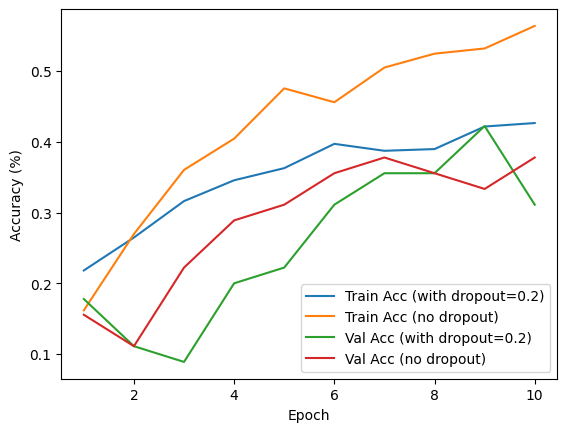

In [ ]:
epochs = range(1, 11)
dropouts_train = [hist_d[x][2] for x in range(len(hist_d))]
no_dropouts_train = [hist_nd[x][2] for x in range(len(hist_nd))]
dropouts_val = [hist_d[x][3] for x in range(len(hist_d))]
no_dropouts_val = [hist_nd[x][3] for x in range(len(hist_nd))]
plt.plot(epochs, dropouts_train, label="Train Acc (with dropout=0.2)")
plt.plot(epochs, no_dropouts_train, label="Train Acc (no dropout)")
plt.plot(epochs, dropouts_val, label="Val Acc (with dropout=0.2)")
plt.plot(epochs, no_dropouts_val, label="Val Acc (no dropout)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, train_dl, valid_dl, epochs, lr):
    train_on_gpu = cuda.is_available()
    device = 'cpu'
    if train_on_gpu:
      device = 'cuda'
      model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_dl))

    history = []


    for epoch in range(epochs):
      train_loss = 0.0
      valid_loss = 0.0
      train_acc = 0
      valid_acc = 0
      lrs = []

      model.train()
      for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lrs.append(get_lr(optimizer))
        sched.step()

        train_loss += loss.item() * images.size(0)
        _, pred = torch.max(outputs, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * images.size(0)


      with torch.no_grad():
        model.eval()
        for images, labels in valid_dl:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)

          valid_loss += loss.item() * images.size(0)
          _, pred = torch.max(outputs, 1)
          correct_tensor = pred.eq(labels.data.view_as(pred))
          accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
          valid_acc += accuracy.item() * images.size(0)

        train_loss = train_loss / len(train_dl.dataset)
        train_acc = train_acc / len(train_dl.dataset)
        valid_loss = valid_loss / len(valid_dl.dataset)
        valid_acc = valid_acc / len(valid_dl.dataset)

        history.append([train_loss, valid_loss, train_acc, valid_acc])

        print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
        print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

    return model, history

In [ ]:
resnet_scratch = models.resnet18(weights=None)

resnet_scratch.fc = nn.Sequential(
    nn.Linear(resnet_scratch.fc.in_features, 7)
)

In [ ]:
resnet_scratch, hist_resnet_dbi = train_model(resnet_scratch,train_dl, val_dl, epochs=20, lr=0.01)


Epoch: 1 	Training Loss: 1.8654 	Validation Loss: 5.1871
		Training Accuracy: 24.02%	 Validation Accuracy: 11.11%

Epoch: 2 	Training Loss: 1.9930 	Validation Loss: 14.1952
		Training Accuracy: 29.90%	 Validation Accuracy: 22.22%

Epoch: 3 	Training Loss: 1.8718 	Validation Loss: 18.0374
		Training Accuracy: 27.94%	 Validation Accuracy: 15.56%

Epoch: 4 	Training Loss: 1.7335 	Validation Loss: 7.7756
		Training Accuracy: 33.33%	 Validation Accuracy: 13.33%

Epoch: 5 	Training Loss: 1.6610 	Validation Loss: 9.7291
		Training Accuracy: 33.58%	 Validation Accuracy: 17.78%

Epoch: 6 	Training Loss: 1.5689 	Validation Loss: 6.7377
		Training Accuracy: 41.42%	 Validation Accuracy: 22.22%

Epoch: 7 	Training Loss: 1.5628 	Validation Loss: 4.2881
		Training Accuracy: 37.99%	 Validation Accuracy: 22.22%

Epoch: 8 	Training Loss: 1.5807 	Validation Loss: 8.8464
		Training Accuracy: 38.97%	 Validation Accuracy: 17.78%

Epoch: 9 	Training Loss: 1.4893 	Validation Loss: 4.6481
		Training Accuracy:

In [ ]:
def evaluate_model(model, dl):
    train_on_gpu = cuda.is_available()
    device = 'cpu'
    if train_on_gpu:
      device = 'cuda'
      model.to(device)

    criterion = nn.CrossEntropyLoss()
    acc = 0
    with torch.no_grad():
      model.eval()
      for images, labels in dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss += loss.item() * images.size(0)
        _, pred = torch.max(outputs, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        acc += accuracy.item() * images.size(0)

    loss = loss / len(dl.dataset)
    acc = acc / len(dl.dataset)
    return acc

In [ ]:
resnet_dbi_test = evaluate_model(resnet_scratch, test_dl)
print("ResNet-18 (from scratch) accuracy on DBI test set:", resnet_dbi_test*100, "%")

ResNet-18 (from scratch) accuracy on DBI test set: 55.44041450777202 %


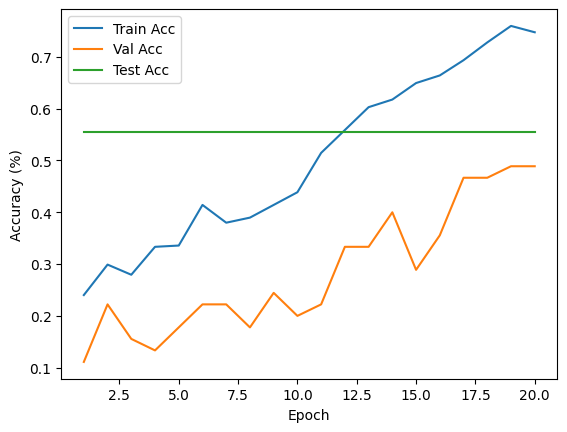

In [ ]:
epochs = range(1, 21)
train = [hist_resnet_dbi[x][2] for x in range(len(hist_resnet_dbi))]
val = [hist_resnet_dbi[x][3] for x in range(len(hist_resnet_dbi))]
test = [resnet_dbi_test for _ in range(len(hist_resnet_dbi))]
plt.plot(epochs, train, label="Train Acc")
plt.plot(epochs, val, label="Val Acc")
plt.plot(epochs, test, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [ ]:
resnet_sdd = evaluate_model(resnet_scratch, sdd_dl)
print("ResNet-18 (from scratch) accuracy on SDD set:", resnet_sdd*100, "%")

ResNet-18 (from scratch) accuracy on SDD set: 35.92233011637691 %


In [ ]:
pre_resnet = models.resnet18(pretrained=True)

pre_input = pre_resnet.fc.in_features
pre_resnet.fc = nn.Linear(pre_input, 7)
pre_resnet, hist_pre_resnet = train_model(pre_resnet, train_dl, val_dl, epochs=10, lr=0.0001)


pre_resnet_dbi = evaluate_model(pre_resnet, test_dl)
print("ResNet-18 (pretrained) accuracy on DBI test set:", pre_resnet_dbi*100, "%")

pre_resnet_sdd = evaluate_model(pre_resnet, sdd_dl)
print("ResNet-18 (pre-trained) accuracy on SDD set:", pre_resnet_sdd*100, "%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 2.1330 	Validation Loss: 1.9461
		Training Accuracy: 17.16%	 Validation Accuracy: 15.56%

Epoch: 2 	Training Loss: 1.7505 	Validation Loss: 1.4402
		Training Accuracy: 30.64%	 Validation Accuracy: 46.67%

Epoch: 3 	Training Loss: 0.9586 	Validation Loss: 0.7094
		Training Accuracy: 81.62%	 Validation Accuracy: 84.44%

Epoch: 4 	Training Loss: 0.4189 	Validation Loss: 0.3548
		Training Accuracy: 94.61%	 Validation Accuracy: 91.11%

Epoch: 5 	Training Loss: 0.2150 	Validation Loss: 0.2475
		Training Accuracy: 98.04%	 Validation Accuracy: 95.56%

Epoch: 6 	Training Loss: 0.1477 	Validation Loss: 0.2032
		Training Accuracy: 98.53%	 Validation Accuracy: 95.56%

Epoch: 7 	Training Loss: 0.1029 	Validation Loss: 0.1856
		Training Accuracy: 99.51%	 Validation Accuracy: 95.56%

Epoch: 8 	Training Loss: 0.0848 	Validation Loss: 0.1800
		Training Accuracy: 100.00%	 Validation Accuracy: 95.56%

Epoch: 9 	Training Loss: 0.0800 	Validation Loss: 0.1764
		Training Accuracy: 

In [ ]:
pre_34 = models.resnet34(pretrained=True)
pre_input = pre_34.fc.in_features
pre_34.fc = nn.Linear(pre_input, 7)
pre_34, hist_pre_34 = train_model(pre_34, train_dl, val_dl, epochs=10, lr=0.0001)

pre_34_dbi = evaluate_model(pre_34, test_dl)
print("ResNet-34 (pretrained) accuracy on DBI test set:", pre_34_dbi*100, "%")

pre_34_sdd = evaluate_model(pre_34, sdd_dl)
print("ResNet-34 (pre-trained) accuracy on SDD set:", pre_34_sdd*100, "%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 2.1108 	Validation Loss: 1.8167
		Training Accuracy: 9.80%	 Validation Accuracy: 28.89%

Epoch: 2 	Training Loss: 1.4758 	Validation Loss: 0.8565
		Training Accuracy: 54.41%	 Validation Accuracy: 88.89%

Epoch: 3 	Training Loss: 0.5176 	Validation Loss: 0.2162
		Training Accuracy: 94.85%	 Validation Accuracy: 93.33%

Epoch: 4 	Training Loss: 0.1549 	Validation Loss: 0.1107
		Training Accuracy: 98.04%	 Validation Accuracy: 100.00%

Epoch: 5 	Training Loss: 0.0688 	Validation Loss: 0.0758
		Training Accuracy: 99.51%	 Validation Accuracy: 97.78%

Epoch: 6 	Training Loss: 0.0390 	Validation Loss: 0.0739
		Training Accuracy: 99.75%	 Validation Accuracy: 97.78%

Epoch: 7 	Training Loss: 0.0317 	Validation Loss: 0.0693
		Training Accuracy: 99.75%	 Validation Accuracy: 97.78%

Epoch: 8 	Training Loss: 0.0267 	Validation Loss: 0.0669
		Training Accuracy: 99.51%	 Validation Accuracy: 97.78%

Epoch: 9 	Training Loss: 0.0207 	Validation Loss: 0.0675
		Training Accuracy: 1

In [ ]:
pre_next = models.resnext50_32x4d(pretrained=True)
pre_input = pre_next.fc.in_features
pre_next.fc = nn.Linear(pre_input, 7)
pre_next, hist_pre_next = train_model(pre_next, train_dl, val_dl, epochs=5, lr=0.0001)

pre_next_dbi = evaluate_model(pre_next, test_dl)
print("ResNext-50 (pretrained) accuracy on DBI test set:", pre_next_dbi*100, "%")

pre_next_sdd = evaluate_model(pre_next, sdd_dl)
print("ResNext-50 (pre-trained) accuracy on SDD set:", pre_next_sdd*100, "%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1 	Training Loss: 1.8681 	Validation Loss: 1.3407
		Training Accuracy: 28.43%	 Validation Accuracy: 95.56%

Epoch: 2 	Training Loss: 0.8720 	Validation Loss: 0.3423
		Training Accuracy: 94.12%	 Validation Accuracy: 100.00%

Epoch: 3 	Training Loss: 0.1648 	Validation Loss: 0.1059
		Training Accuracy: 99.51%	 Validation Accuracy: 100.00%

Epoch: 4 	Training Loss: 0.0582 	Validation Loss: 0.0759
		Training Accuracy: 99.75%	 Validation Accuracy: 100.00%

Epoch: 5 	Training Loss: 0.0398 	Validation Loss: 0.0741
		Training Accuracy: 100.00%	 Validation Accuracy: 100.00%
ResNext-50 (pretrained) accuracy on DBI test set: 97.40932642487047 %
ResNext-50 (pre-trained) accuracy on SDD set: 94.01294496452924 %


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = ImageFolder("./Dataset_Classification", transform=transform)

In [ ]:
print("Classes:", master_dataset.classes)
print("Number of images total:", len(dataset))

Classes: ['DBI', 'SDD']
Number of images total: 1879


In [ ]:
dbi_sdd_size = len(dataset)
test_size = int(0.2 * dbi_sdd_size)
val_size  = int(0.1 * dbi_sdd_size)
train_size= dbi_sdd_size - test_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size)
val_dl   = DataLoader(val_ds,   batch_size=batch_size)
test_dl  = DataLoader(test_ds,  batch_size=batch_size)

In [ ]:
model = models.resnext50_32x4d(pretrained=True)
input = model.fc.in_features
model.fc = nn.Linear(input, 2)
model, hist = train_model(model, train_dl, val_dl, epochs=5, lr=0.0001)

model_acc = evaluate_model(model, test_dl)
print("Dataset Classification accuracy on test set:", model_acc*100, "%")


Epoch: 1 	Training Loss: 0.5461 	Validation Loss: 0.4010
		Training Accuracy: 70.31%	 Validation Accuracy: 78.61%

Epoch: 2 	Training Loss: 0.1868 	Validation Loss: 0.4145
		Training Accuracy: 92.26%	 Validation Accuracy: 81.28%

Epoch: 3 	Training Loss: 0.0304 	Validation Loss: 0.4067
		Training Accuracy: 99.01%	 Validation Accuracy: 85.03%

Epoch: 4 	Training Loss: 0.0084 	Validation Loss: 0.4532
		Training Accuracy: 99.92%	 Validation Accuracy: 84.49%

Epoch: 5 	Training Loss: 0.0030 	Validation Loss: 0.4507
		Training Accuracy: 100.00%	 Validation Accuracy: 84.49%
Dataset Classification accuracy on test set: 86.93333322207133 %
